In [103]:
path = "artifacts/gbug-java.csv"

import pandas as pd
df = pd.read_csv(path)
print(df.shape)

(148, 3)


In [128]:
path = "gpt2_gbug-java"

In [129]:
# for each folder within this that starts with "layer", grab the values from the jsonl files
import os
import json
import re
import pandas as pd

def parse_jsonl(data):
    parsed_data = []
    for line in data:
        parsed_data.append(json.loads(line))

    return parsed_data


main_df = pd.DataFrame()
for root, dirs, files in os.walk(path):
    if "layer" not in root:
        continue

    for file in files:
        file_in_question = "logistic_regression.jsonl"

        if file == file_in_question:
            with open(os.path.join(root, file)) as f:
                data = f.readlines()


            parsed_data = parse_jsonl(data)
            df = pd.DataFrame(parsed_data)
            
            # We have tp, fp, tn, fn
            # We want precision, recall, f1
            df["precision"] = df["tp"] / (df["tp"] + df["fp"])
            df["recall"] = df["tp"] / (df["tp"] + df["fn"])
            df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])
            df["accuracy"] = (df["tp"] + df["tn"]) / (df["tp"] + df["tn"] + df["fp"] + df["fn"])
            df["layer"] = re.search(r"layer(\d+)", root).group(1)

            main_df = pd.concat([main_df, df])


In [130]:
main_df

,classifier,n_features,tp,fp,tn,fn,y_pred,y_test,precision,recall,f1,accuracy,layer
0,logistic_regression,1,6,5,25,24,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.545455,0.200000,0.292683,0.516667,11
1,logistic_regression,2,16,13,17,14,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.551724,0.533333,0.542373,0.550000,11
2,logistic_regression,3,15,12,18,15,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.555556,0.500000,0.526316,0.550000,11
3,logistic_regression,4,21,15,15,9,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.583333,0.700000,0.636364,0.600000,11
4,logistic_regression,5,20,17,13,10,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.540541,0.666667,0.597015,0.550000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,logistic_regression,95,20,9,21,10,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.689655,0.666667,0.677966,0.683333,3
95,logistic_regression,96,22,10,20,8,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.687500,0.733333,0.709677,0.700000,3
96,logistic_regression,97,21,10,20,9,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.677419,0.700000,0.688525,0.683333,3
97,logistic_regression,98,21,9,21,9,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.700000,0.700000,0.700000,0.700000,3


In [131]:
# reset index
main_df = main_df.reset_index(drop=False)
main_df

,index,classifier,n_features,tp,fp,tn,fn,y_pred,y_test,precision,recall,f1,accuracy,layer
0,0,logistic_regression,1,6,5,25,24,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.545455,0.200000,0.292683,0.516667,11
1,1,logistic_regression,2,16,13,17,14,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.551724,0.533333,0.542373,0.550000,11
2,2,logistic_regression,3,15,12,18,15,"[1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.555556,0.500000,0.526316,0.550000,11
3,3,logistic_regression,4,21,15,15,9,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.583333,0.700000,0.636364,0.600000,11
4,4,logistic_regression,5,20,17,13,10,"[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.540541,0.666667,0.597015,0.550000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,94,logistic_regression,95,20,9,21,10,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.689655,0.666667,0.677966,0.683333,3
1184,95,logistic_regression,96,22,10,20,8,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.687500,0.733333,0.709677,0.700000,3
1185,96,logistic_regression,97,21,10,20,9,"[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.677419,0.700000,0.688525,0.683333,3
1186,97,logistic_regression,98,21,9,21,9,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.700000,0.700000,0.700000,0.700000,3


In [132]:
top_k_to_show = [1,5, 10, 25, 50, 99]

# create a table with the top k values as columns and the layers as rows. write the f1 values in the cells
table = pd.DataFrame()
for k in top_k_to_show:
    table[k] = main_df[main_df["n_features"] == k].set_index("layer")["accuracy"]


# convert the index into integers
table.index = table.index.astype(int)

# sort the rows by the index
table = table.sort_index()
table

,1,5,10,25,50,99
layer,,,,,,
0,0.583333,0.633333,0.633333,0.650000,0.650000,0.650000
1,0.583333,0.666667,0.616667,0.550000,0.650000,0.700000
2,0.616667,0.616667,0.616667,0.650000,0.683333,0.733333
3,0.616667,0.650000,0.616667,0.700000,0.716667,0.683333
4,0.650000,0.650000,0.650000,0.566667,0.716667,0.716667
5,0.666667,0.683333,0.566667,0.616667,0.666667,0.716667
6,0.683333,0.666667,0.666667,0.650000,0.683333,0.683333
7,0.683333,0.683333,0.650000,0.583333,0.650000,0.650000
8,0.616667,0.616667,0.700000,0.650000,0.700000,0.700000


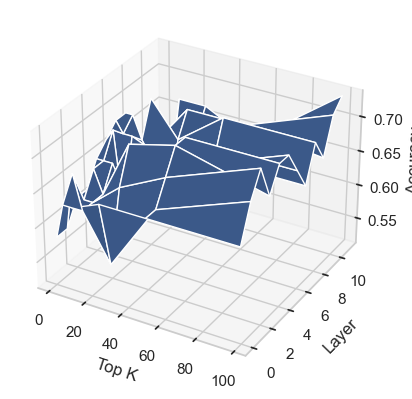

In [133]:
# plot the table in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array(table.columns)
y = np.array(table.index)
X, Y = np.meshgrid(x, y)
Z = np.array(table)

ax.plot_surface(X, Y, Z)
# add axis labels
ax.set_xlabel('Top K')
ax.set_ylabel('Layer')
ax.set_zlabel('Accuracy')
plt.show()





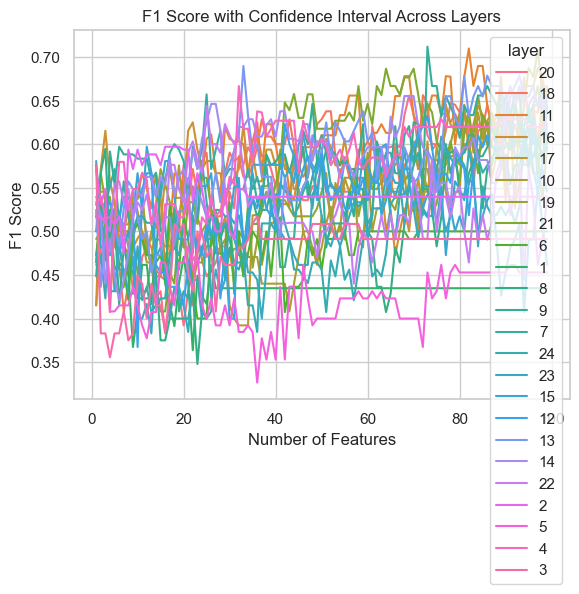

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot mean F1 score across all layers
sns.lineplot(data=main_df, x="n_features", y="f1", hue="layer")

plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("F1 Score with Confidence Interval Across Layers")
plt.show()


/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_82725/3383640940.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=main_df, x="n_features", y=ACTIVE_METRIC.name, ci=95, label=f"Mean {ACTIVE_METRIC.label}", color="black", linestyle="dashed")


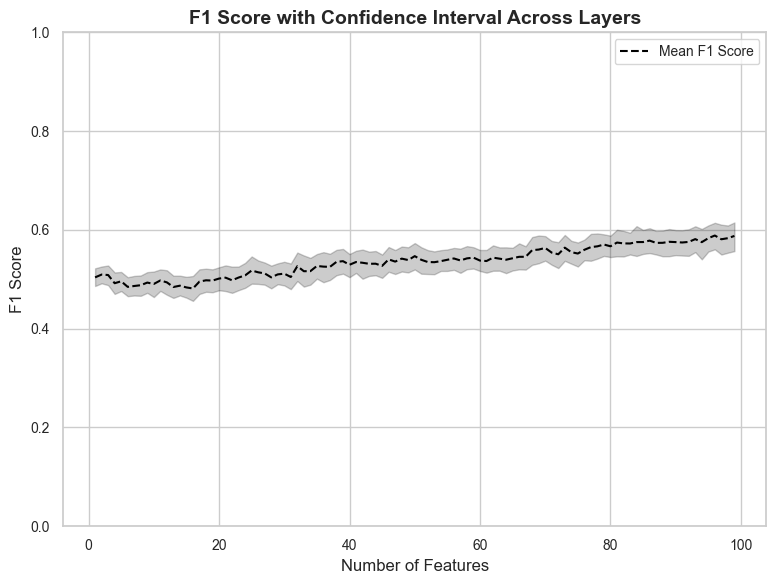

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set_style("whitegrid")

from dataclasses import dataclass

@dataclass
class Metric:
    name: str
    label: str

F1 = Metric("f1", "F1 Score")
ACCURACY = Metric("accuracy", "Accuracy")

ACTIVE_METRIC = F1

# Create the figure
plt.figure(figsize=(8, 6))

# Plot mean F1 score across all layers with confidence interval
sns.lineplot(data=main_df, x="n_features", y=ACTIVE_METRIC.name, ci=95, label=f"Mean {ACTIVE_METRIC.label}", color="black", linestyle="dashed")

# Plot Layer 11
# df_11 = main_df[main_df["layer"] == "11"]
# plt.plot(df_11["n_features"], df_11[ACTIVE_METRIC.name], label="Layer 11", color="red", linestyle="-",alpha=0.3)

# # Plot Layer 1
# df_1 = main_df[main_df["layer"] == "1"]
# plt.plot(df_1["n_features"], df_1[ACTIVE_METRIC.name], label="Layer 1", color="blue", linestyle="-",alpha=0.3)

# Labels and title
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel(ACTIVE_METRIC.label, fontsize=12)
plt.title(f"{ACTIVE_METRIC.label} with Confidence Interval Across Layers", fontsize=14, fontweight="bold")

# Add a legend
plt.legend(fontsize=10)

# Improve layout
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#define axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()
